# **Environment Setup**

In [1]:
!nvidia-smi

Mon May 17 05:25:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os, shutil

sys.path.append('/usr/local/lib/python3.7/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ["CONDA_PREFIX"] = "/usr/local"
for so in ['cudf', 'rmm', 'nccl', 'cuml', 'cugraph', 'xgboost', 'cuspatial']:
  fn = 'lib'+so+'.so'
  source_fn = '/usr/local/lib/'+fn
  dest_fn = '/usr/lib/'+fn
  if os.path.exists(source_fn):
    print(f'Copying {source_fn} to {dest_fn}')
    shutil.copyfile(source_fn, dest_fn)
# fix for BlazingSQL import issue
# ImportError: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /usr/local/lib/python3.7/site-packages/../../libblazingsql-engine.so)
if not os.path.exists('/usr/lib64'):
    os.makedirs('/usr/lib64')
for so_file in os.listdir('/usr/local/lib'):
  if 'libstdc' in so_file:
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib64/'+so_file)
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib/x86_64-linux-gnu/'+so_file)

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 238 (delta 36), reused 11 (delta 5), pack-reused 171
Receiving objects: 100% (238/238), 73.89 KiB | 2.11 MiB/s, done.
Resolving deltas: 100% (98/98), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.19 and 0.20)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.19

	import sys, os, shutil

	sys.path.append('/usr/local/lib/python3.7/site-packages/')
	os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
	os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
	os.environ['CONDA_PREFIX'] = '/usr/local'
	for so in ['cudf', 'rmm', 

# Data Pre-processing

In [45]:
!nvcc -V && which nvcc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
/usr/local/cuda/bin/nvcc


In [46]:
# In case you get an import error, run again notebook cell number 3, 
# to install again miniconda and RAPIDS dependencies. If the problem persists,
# Go to Runtime -> Reset all runtimes and then run again the noebook cells (two 
# times the one for installing miniconda and RAPIDS dependencies)
import cudf
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
movie_df_cudf = cudf.read_csv('/content/drive/MyDrive/Learning/DataBootcamp/Final-project/Data/IMDb movies.csv') 
movie_df_cudf_pd=movie_df_cudf.to_pandas()
movie_df_cudf_pd.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,None,None,None,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,None,None,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",None,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,None,None,None,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,None,None,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,None,None,None,NaN,31.0,14.0


In [169]:
movie_df_cudf_pd.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [170]:
reduced_df = movie_df_cudf_pd[['original_title', 'year',
       'genre', 'duration', 'country', 'director', 'writer',
       'production_company', 'actors', 'avg_vote', 'votes',
       'budget', 'worlwide_gross_income']]

reduced_df

,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
0,Miss Jerry,1894,Romance,45,USA,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",5.9,154,None,None
1,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",6.1,589,$ 2250,None
2,Den sorte drøm,1911,Drama,53,"Germany, Denmark",Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",5.8,188,None,None
3,Cleopatra,1912,"Drama, History",100,USA,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",5.2,446,$ 45000,None
4,L'Inferno,1911,"Adventure, Drama, Fantasy",68,Italy,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",7.0,2237,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,Le lion,2020,Comedy,95,"France, Belgium",Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",5.3,398,None,$ 3507171
85851,De Beentjes van Sint-Hildegard,2020,"Comedy, Drama",103,Netherlands,Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",7.7,724,None,$ 7299062
85852,Padmavyuhathile Abhimanyu,2019,Drama,130,India,Vineesh Aaradya,"Vineesh Aaradya, Vineesh Aaradya",RMCC Productions,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",7.9,265,None,None
85853,Sokagin Çocuklari,2019,"Drama, Family",98,Turkey,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",6.4,194,None,$ 2833


In [171]:
len(reduced_df)

85855

In [172]:
test_clean_df = reduced_df.dropna()

In [173]:
test_clean_df

,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
165,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,$ 18000,$ 8811
210,Markens grøde,1921,Drama,107,Norway,Gunnar Sommerfeldt,"Knut Hamsun, Gunnar Sommerfeldt",Christiana Film,"Amund Rydland, Karen Poulsen, Ragna Wettergree...",6.6,195,NOK 250000,$ 4272
245,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,$ 800000,$ 9183673
251,The Kid,1921,"Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,$ 250000,$ 26916
348,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,$ 351000,$ 11233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85823,Subharathri,2019,"Drama, Romance",130,India,Vyasan K.P.,"Vyasan K.P., Vyasan K.P.",Abaam Movies,"Dileep, Anu Sithara, Siddique, Suraj Venjaramo...",6.0,202,INR 30000000,$ 105932
85828,Munthiri Monchan,2019,"Comedy, Romance",130,India,Vijith Nambiar,"Manu Gopal, Meharali Poilungal Ismail",Vishvas Movies,"Manesh Krishnan, Gopika Anil, Salim Kumar, Dev...",8.1,990,INR 30000000,$ 2568
85835,Upin & Ipin: Keris Siamang Tunggal,2019,Animation,100,Malaysia,"Adam Bin Amiruddin, Syed Nurfaiz Khalid bin Sy...","Hjh. Ainon Ariff, Nur Naquyah bt Burhanuddin",Les' Copaque Production,"Asyiela Putri Bt Azhar, Mohd Amir Asyraf Bin M...",7.9,440,MYR 20000000,$ 83857
85843,Kaithi,2019,"Action, Thriller",145,India,Lokesh Kanagaraj,"Lokesh Kanagaraj, Pon Parthiban",Dream Warrior Pictures,"Karthi, Narain, Ramana, George Maryan, Harish ...",8.5,8400,INR 240000000,$ 524061


In [174]:
test_clean_df    

,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
165,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,$ 18000,$ 8811
210,Markens grøde,1921,Drama,107,Norway,Gunnar Sommerfeldt,"Knut Hamsun, Gunnar Sommerfeldt",Christiana Film,"Amund Rydland, Karen Poulsen, Ragna Wettergree...",6.6,195,NOK 250000,$ 4272
245,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,$ 800000,$ 9183673
251,The Kid,1921,"Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,$ 250000,$ 26916
348,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,$ 351000,$ 11233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85823,Subharathri,2019,"Drama, Romance",130,India,Vyasan K.P.,"Vyasan K.P., Vyasan K.P.",Abaam Movies,"Dileep, Anu Sithara, Siddique, Suraj Venjaramo...",6.0,202,INR 30000000,$ 105932
85828,Munthiri Monchan,2019,"Comedy, Romance",130,India,Vijith Nambiar,"Manu Gopal, Meharali Poilungal Ismail",Vishvas Movies,"Manesh Krishnan, Gopika Anil, Salim Kumar, Dev...",8.1,990,INR 30000000,$ 2568
85835,Upin & Ipin: Keris Siamang Tunggal,2019,Animation,100,Malaysia,"Adam Bin Amiruddin, Syed Nurfaiz Khalid bin Sy...","Hjh. Ainon Ariff, Nur Naquyah bt Burhanuddin",Les' Copaque Production,"Asyiela Putri Bt Azhar, Mohd Amir Asyraf Bin M...",7.9,440,MYR 20000000,$ 83857
85843,Kaithi,2019,"Action, Thriller",145,India,Lokesh Kanagaraj,"Lokesh Kanagaraj, Pon Parthiban",Dream Warrior Pictures,"Karthi, Narain, Ramana, George Maryan, Harish ...",8.5,8400,INR 240000000,$ 524061


In [265]:
usa_df=test_clean_df[test_clean_df["budget"].str.startswith("$")]
usa_df=usa_df[test_clean_df["worlwide_gross_income"].str.startswith("$")]
usa_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
165,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,$ 18000,$ 8811
245,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,$ 800000,$ 9183673
251,The Kid,1921,"Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,$ 250000,$ 26916
348,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,$ 351000,$ 11233
415,The Gold Rush,1925,"Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,$ 923000,$ 26916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85477,Plane Tree,2018,Drama,99,Turkey,Mustafa Karadeniz,"Necip Güleçer, Mustafa Karadeniz",Cinar Film Yapim,"Sezgin Cengiz, Silan Düzdaban, Yunus Emre Çeli...",6.8,168,$ 200000,$ 4183
85530,Doblemente Embarazada,2019,Comedy,98,Mexico,Koko Stambuk,"Diego Ayala, Koko Stambuk",SDB Films,"Roberta Burns, Gustavo Egelhaaf, Luis Felipe C...",4.4,197,$ 950000,$ 965558
85592,Quezon's Game,2018,"Drama, History",127,Philippines,Matthew E. Rosen,"Janice Y. Perez, Dean Rosen",Star Cinema,"Raymond Bagatsing, Rachel Alejandro, Kate Alej...",7.5,117,$ 500000,$ 5986
85740,I Still Believe,2020,"Biography, Drama, Music",116,USA,"Andrew Erwin, Jon Erwin","Jeremy Camp, Jon Erwin",Kevin Downes Productions,"K.J. Apa, Britt Robertson, Nathan Parsons, Gar...",6.5,6196,$ 12000000,$ 13681524


In [266]:
usa_df['budget'] = usa_df['budget'].str.replace('$','')
usa_df['worlwide_gross_income'] = usa_df['worlwide_gross_income'].str.replace('$','')
usa_df

,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
165,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811
245,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673
251,The Kid,1921,"Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916
348,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233
415,The Gold Rush,1925,"Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85477,Plane Tree,2018,Drama,99,Turkey,Mustafa Karadeniz,"Necip Güleçer, Mustafa Karadeniz",Cinar Film Yapim,"Sezgin Cengiz, Silan Düzdaban, Yunus Emre Çeli...",6.8,168,200000,4183
85530,Doblemente Embarazada,2019,Comedy,98,Mexico,Koko Stambuk,"Diego Ayala, Koko Stambuk",SDB Films,"Roberta Burns, Gustavo Egelhaaf, Luis Felipe C...",4.4,197,950000,965558
85592,Quezon's Game,2018,"Drama, History",127,Philippines,Matthew E. Rosen,"Janice Y. Perez, Dean Rosen",Star Cinema,"Raymond Bagatsing, Rachel Alejandro, Kate Alej...",7.5,117,500000,5986
85740,I Still Believe,2020,"Biography, Drama, Music",116,USA,"Andrew Erwin, Jon Erwin","Jeremy Camp, Jon Erwin",Kevin Downes Productions,"K.J. Apa, Britt Robertson, Nathan Parsons, Gar...",6.5,6196,12000000,13681524


In [267]:
usa_df['budget'] = usa_df['budget'].astype(int)
usa_df['worlwide_gross_income'] = usa_df['worlwide_gross_income'].astype(int)

In [268]:
usa_df['year'] = usa_df['year'].astype(int)

In [269]:
usa_df.dtypes

original_title            object
year                       int64
genre                     object
duration                   int64
country                   object
director                  object
writer                    object
production_company        object
actors                    object
avg_vote                 float64
votes                      int64
budget                     int64
worlwide_gross_income      int64
dtype: object

In [270]:
usa_df.head()

,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
165,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811
245,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673
251,The Kid,1921,"Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916
348,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233
415,The Gold Rush,1925,"Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916


In [271]:
usa_df.shape

(8936, 13)

In [272]:
print('Number of genres in films')
usa_df['genre'].apply(lambda x: len(x.split(', '))).value_counts()

Number of genres in films


3    5392
2    2417
1    1127
Name: genre, dtype: int64

In [273]:
list_of_genres = list(usa_df['genre'].apply(lambda x:  [i for i in x.split(', ')]).values)

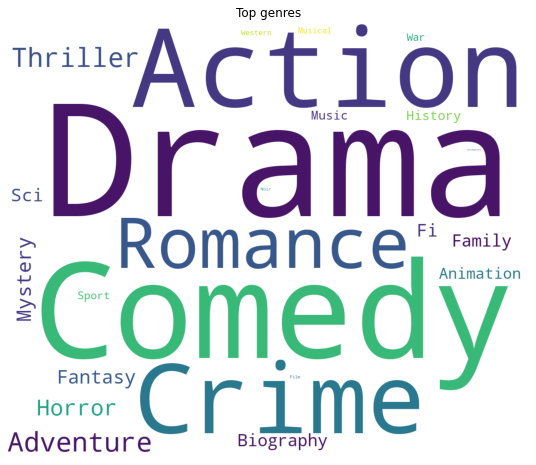

In [274]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

In [275]:
from collections import Counter
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 4803),
 ('Comedy', 3354),
 ('Action', 2138),
 ('Crime', 1661),
 ('Romance', 1531),
 ('Adventure', 1516),
 ('Thriller', 1444),
 ('Horror', 971),
 ('Mystery', 762),
 ('Fantasy', 693),
 ('Sci-Fi', 593),
 ('Family', 545),
 ('Biography', 535),
 ('Animation', 431),
 ('History', 303),
 ('Music', 254),
 ('Sport', 206),
 ('War', 190),
 ('Musical', 108),
 ('Western', 81),
 ('Film-Noir', 17),
 ('Documentary', 1)]

In [276]:
genre_type=Counter([i for j in list_of_genres for i in j]).most_common()
genre_type[0][0]

'Drama'

In [277]:
all_genres = [x[0] for x in Counter([i for j in list_of_genres for i in j]).most_common()]
all_genres

['Drama',
 'Comedy',
 'Action',
 'Crime',
 'Romance',
 'Adventure',
 'Thriller',
 'Horror',
 'Mystery',
 'Fantasy',
 'Sci-Fi',
 'Family',
 'Biography',
 'Animation',
 'History',
 'Music',
 'Sport',
 'War',
 'Musical',
 'Western',
 'Film-Noir',
 'Documentary']

In [278]:
for genre in all_genres:
  usa_df['genre_' + genre] = usa_df['genre'].apply(lambda x: 1 if genre in x.split(', ') else 0)

In [279]:
usa_df.head()

,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income,genre_Drama,genre_Comedy,genre_Action,genre_Crime,genre_Romance,genre_Adventure,genre_Thriller,genre_Horror,genre_Mystery,genre_Fantasy,genre_Sci-Fi,genre_Family,genre_Biography,genre_Animation,genre_History,genre_Music,genre_Sport,genre_War,genre_Musical,genre_Western,genre_Film-Noir,genre_Documentary
165,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
245,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
251,The Kid,1921,"Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
348,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
415,The Gold Rush,1925,"Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [280]:
print('Number of countries')
usa_df['country'].apply(lambda x: len(x.split(', '))).value_counts()

Number of countries


1     5894
2     1888
3      730
4      250
5      106
6       38
7       12
8       12
9        3
14       1
11       1
10       1
Name: country, dtype: int64

In [281]:
list_of_countries = list(usa_df['country'].apply(lambda x:  [i for i in x.split(', ')]).values)

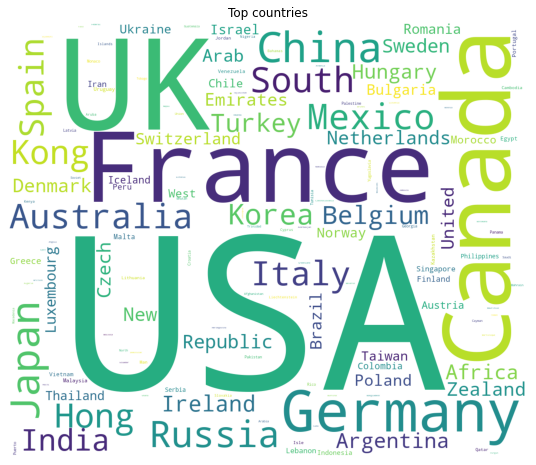

In [282]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_countries for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top countries')
plt.axis("off")
plt.show()

In [283]:
Counter([i for j in list_of_countries for i in j]).most_common()[:30]

[('USA', 7112),
 ('UK', 1313),
 ('France', 705),
 ('Canada', 655),
 ('Germany', 604),
 ('China', 282),
 ('Japan', 261),
 ('Russia', 213),
 ('Mexico', 199),
 ('Australia', 183),
 ('Hong Kong', 180),
 ('Italy', 179),
 ('Spain', 177),
 ('India', 142),
 ('South Korea', 130),
 ('Belgium', 97),
 ('Turkey', 96),
 ('Ireland', 74),
 ('Argentina', 66),
 ('South Africa', 62),
 ('Hungary', 59),
 ('Sweden', 55),
 ('New Zealand', 52),
 ('Denmark', 51),
 ('Czech Republic', 51),
 ('Netherlands', 50),
 ('United Arab Emirates', 44),
 ('Switzerland', 38),
 ('Brazil', 37),
 ('Poland', 36)]

In [284]:
top_countries = [x[0] for x in Counter([i for j in list_of_countries for i in j]).most_common()[:30]]
top_countries

['USA',
 'UK',
 'France',
 'Canada',
 'Germany',
 'China',
 'Japan',
 'Russia',
 'Mexico',
 'Australia',
 'Hong Kong',
 'Italy',
 'Spain',
 'India',
 'South Korea',
 'Belgium',
 'Turkey',
 'Ireland',
 'Argentina',
 'South Africa',
 'Hungary',
 'Sweden',
 'New Zealand',
 'Denmark',
 'Czech Republic',
 'Netherlands',
 'United Arab Emirates',
 'Switzerland',
 'Brazil',
 'Poland']

In [285]:
for country in top_countries:
  usa_df['country_' + country] = usa_df['country'].apply(lambda x: 1 if country in x.split(', ') else 0)

In [286]:
usa_df.head()

,original_title,year,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income,genre_Drama,genre_Comedy,genre_Action,genre_Crime,genre_Romance,genre_Adventure,genre_Thriller,genre_Horror,genre_Mystery,genre_Fantasy,genre_Sci-Fi,genre_Family,genre_Biography,genre_Animation,genre_History,genre_Music,genre_Sport,genre_War,genre_Musical,genre_Western,genre_Film-Noir,genre_Documentary,country_USA,country_UK,country_France,country_Canada,country_Germany,country_China,country_Japan,country_Russia,country_Mexico,country_Australia,country_Hong Kong,country_Italy,country_Spain,country_India,country_South Korea,country_Belgium,country_Turkey,country_Ireland,country_Argentina,country_South Africa,country_Hungary,country_Sweden,country_New Zealand,country_Denmark,country_Czech Republic,country_Netherlands,country_United Arab Emirates,country_Switzerland,country_Brazil,country_Poland
165,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
245,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
251,The Kid,1921,"Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
348,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
415,The Gold Rush,1925,"Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [287]:
usa_df.shape

(8936, 65)

In [288]:
print('Number of actors')
usa_df['actors'].apply(lambda x: len(x.split(', '))).value_counts()

Number of actors


15    8165
14     112
13     108
11      99
10      90
12      85
9       62
8       53
7       50
6       35
5       32
3       20
4       15
2        5
1        5
Name: actors, dtype: int64

In [289]:
usa_df['actors'].apply(lambda x: len(x.split(', '))).value_counts()
list_of_actors = list(usa_df['actors'].apply(lambda x:  [i for i in x.split(', ')]).values)
rd_list_of_actors=[x[0:5] for x in list_of_actors]

In [290]:
all_actors = Counter([i for j in rd_list_of_actors for i in j]).most_common()

In [291]:
top_actors = [x[0] for x in all_actors if x[1]>10]

In [292]:
len(top_actors)

680

In [293]:
usa_df['director'].apply(lambda x: len(x.split(', '))).value_counts()
list_of_directors = list(usa_df['director'].apply(lambda x:  [i for i in x.split(', ')]).values)
all_directors = Counter([i for j in list_of_directors for i in j]).most_common()

In [294]:
top_directors = [x[0] for x in all_directors if x[1]>=5]

In [295]:
len(top_directors)

431

In [296]:
usa_df['writer'].apply(lambda x: len(x.split(', '))).value_counts()
list_of_writers = list(usa_df['writer'].apply(lambda x:  [i for i in x.split(', ')]).values)
all_writers = Counter([i for j in list_of_writers for i in j]).most_common()

In [297]:
top_writers = [x[0] for x in all_writers if x[1]>=5]
len(top_writers)

491

In [298]:
usa_df['production_company'].apply(lambda x: len(x.split(', '))).value_counts()
list_of_companies = list(usa_df['production_company'].apply(lambda x:  [i for i in x.split(', ')]).values)
all_companies = Counter([i for j in list_of_companies for i in j]).most_common()

In [299]:
top_companies = [x[0] for x in all_companies if x[1]>=5]
len(top_companies)

187

In [300]:
for director in top_directors:
  usa_df['director_' + director] = usa_df['director'].apply(lambda x: 1 if director in x.split(', ') else 0)

In [301]:
for writer in top_writers:
  usa_df['writer_' + writer] = usa_df['writer'].apply(lambda x: 1 if writer in x.split(', ') else 0)

In [302]:
for company in top_companies:
  usa_df['company_' + company] = usa_df['production_company'].apply(lambda x: 1 if company in x.split(', ') else 0)

In [303]:
for actor in top_actors:
  usa_df['actor_' + actor] = usa_df['actors'].apply(lambda x: 1 if actor in x.split(', ')[0:5] else 0)

In [304]:
usa_df.shape

(8936, 1854)

In [305]:
usa_df=usa_df.reset_index(drop=True)

In [306]:
sample_df=usa_df.select_dtypes(include=['int64','float64'])

# Model test

In [307]:
sample_df.head()

,year,duration,avg_vote,votes,budget,worlwide_gross_income,genre_Drama,genre_Comedy,genre_Action,genre_Crime,genre_Romance,genre_Adventure,genre_Thriller,genre_Horror,genre_Mystery,genre_Fantasy,genre_Sci-Fi,genre_Family,genre_Biography,genre_Animation,genre_History,genre_Music,genre_Sport,genre_War,genre_Musical,genre_Western,genre_Film-Noir,genre_Documentary,country_USA,country_UK,country_France,country_Canada,country_Germany,country_China,country_Japan,country_Russia,country_Mexico,country_Australia,country_Hong Kong,country_Italy,...,actor_Johnathon Schaech,actor_Regina King,actor_Anne Heche,actor_James Cromwell,actor_Dougray Scott,actor_Michael Clarke Duncan,actor_Emily Watson,actor_Judy Greer,actor_Allison Janney,actor_Carmen Ejogo,actor_Michael Angarano,actor_Ziyi Zhang,actor_Kerry Washington,actor_Jason Segel,actor_Paul Dano,actor_Kate Mara,actor_Qi Shu,actor_Karl Urban,actor_Michael Sheen,actor_Diane Kruger,actor_Frank Grillo,actor_Daniel Wu,actor_Vanessa Hudgens,actor_Adam Brody,actor_John Corbett,actor_Michael Ealy,actor_Christoph Waltz,actor_John Krasinski,actor_Eddie Marsan,actor_Rob Corddry,actor_Matthew Goode,actor_Edgar Ramírez,actor_Tyler Perry,actor_Sebastian Stan,actor_Rebecca Hall,actor_Cam Gigandet,actor_Miles Teller,actor_Scott Adkins,actor_Octavia Spencer,actor_Dave Bautista
0,1920,76,8.1,55601,18000,8811,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1921,150,7.2,3058,800000,9183673,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1921,68,8.3,109038,250000,26916,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1923,82,7.0,4735,351000,11233,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1925,95,8.2,97480,923000,26916,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [310]:
X = sample_df.drop(["avg_vote","votes","worlwide_gross_income"], axis=1)

In [311]:
X.head()

,year,duration,budget,genre_Drama,genre_Comedy,genre_Action,genre_Crime,genre_Romance,genre_Adventure,genre_Thriller,genre_Horror,genre_Mystery,genre_Fantasy,genre_Sci-Fi,genre_Family,genre_Biography,genre_Animation,genre_History,genre_Music,genre_Sport,genre_War,genre_Musical,genre_Western,genre_Film-Noir,genre_Documentary,country_USA,country_UK,country_France,country_Canada,country_Germany,country_China,country_Japan,country_Russia,country_Mexico,country_Australia,country_Hong Kong,country_Italy,country_Spain,country_India,country_South Korea,...,actor_Johnathon Schaech,actor_Regina King,actor_Anne Heche,actor_James Cromwell,actor_Dougray Scott,actor_Michael Clarke Duncan,actor_Emily Watson,actor_Judy Greer,actor_Allison Janney,actor_Carmen Ejogo,actor_Michael Angarano,actor_Ziyi Zhang,actor_Kerry Washington,actor_Jason Segel,actor_Paul Dano,actor_Kate Mara,actor_Qi Shu,actor_Karl Urban,actor_Michael Sheen,actor_Diane Kruger,actor_Frank Grillo,actor_Daniel Wu,actor_Vanessa Hudgens,actor_Adam Brody,actor_John Corbett,actor_Michael Ealy,actor_Christoph Waltz,actor_John Krasinski,actor_Eddie Marsan,actor_Rob Corddry,actor_Matthew Goode,actor_Edgar Ramírez,actor_Tyler Perry,actor_Sebastian Stan,actor_Rebecca Hall,actor_Cam Gigandet,actor_Miles Teller,actor_Scott Adkins,actor_Octavia Spencer,actor_Dave Bautista
0,1920,76,18000,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1921,150,800000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1921,68,250000,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1923,82,351000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1925,95,923000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [312]:
vote_y=sample_df["avg_vote"]
nvote_y=sample_df["votes"]
revenue_y=sample_df["worlwide_gross_income"]

In [313]:
from sklearn.model_selection import train_test_split
X_train, X_test, revenue_y_train, revenue_y_test = train_test_split(X, revenue_y)

In [318]:
print('X_train dimensions: ', X_train.shape, 'y_train: ', revenue_y_train.shape)
print('X_test dimensions:', X_test.shape, 'y_validation: ', revenue_y_test.shape)

X_train dimensions:  (6702, 1844) y_train:  (6702,)
X_test dimensions: (2234, 1844) y_validation:  (2234,)


In [314]:
from xgboost import XGBRegressor
regressor = XGBRegressor(colsample_bytree= 0.6, gamma= 0.7, max_depth= 4, min_child_weight= 5,
                         subsample = 0.8, objective='reg:squarederror')
regressor.fit(X_train, revenue_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.7, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [316]:
revenue_y_pred = regressor.predict(X_test)
from sklearn.metrics import r2_score
score = r2_score(revenue_y_test, revenue_y_pred)

/usr/local/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [333]:
revenue_dtrain = xgb.DMatrix(X_train, label=revenue_y_train)
revenue_dtest = xgb.DMatrix(X_test, label=revenue_y_test)

In [445]:
params = {"n_estimators":100,
          "learning_rate": 0.9,
          "subsample":0.8,
          "random_state":2020,
          "colsample_bytree": 0.6,
          "gamma": 0.1,
          "max_depth": 3,
          "min_child_weight": 1,
          "subsample": 0.8, 
          "objective":"reg:squarederror",
          "reg_alpha":0.01,
          "tree_method":"gpu_hist"}

In [446]:
revenue_model=xgb.train(params,revenue_dtrain)

[12:50:20] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1619020798773/work/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [447]:
revenue_y_pred = revenue_model.predict(revenue_dtest)
revenue_y_pred

array([-1.1021950e+05, -1.1021950e+05,  2.2930891e+08, ...,
        3.1379032e+07,  2.1662664e+08,  2.4794260e+07], dtype=float32)

In [448]:
rapids_acc = r2_score(revenue_y_test, revenue_y_pred)
print("XGB accuracy using RAPIDS:", rapids_acc*100, '%')

XGB accuracy using RAPIDS: 65.39191897051927 %


In [317]:
print(score)

0.6263789435266516
